## **Data Loading**

In [ ]:
import pandas as pd
import numpy as np
import random
import os
import pandas as pd
from datetime import datetime
import time

In [ ]:
url = 'https://raw.githubusercontent.com/anhphuongnguyenquynh/session-based-recsys-fashion/main/dataset/item_features.csv'
item_features = pd.read_csv(url)

In [ ]:
url = 'https://raw.githubusercontent.com/anhphuongnguyenquynh/session-based-recsys-fashion/main/dressipi_recsys2022_datasets.zip'
!wget $url
!unzip dressipi_recsys2022_datasets.zip

--2024-04-19 09:39:18--  https://raw.githubusercontent.com/anhphuongnguyenquynh/session-based-recsys-fashion/main/dressipi_recsys2022_datasets.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 79384785 (76M) [application/zip]
Saving to: ‘dressipi_recsys2022_datasets.zip’

dressipi_recsys2022 100%[===================>]  75.71M   345MB/s    in 0.2s    

2024-04-19 09:39:20 (345 MB/s) - ‘dressipi_recsys2022_datasets.zip’ saved [79384785/79384785]

Archive:  dressipi_recsys2022_datasets.zip
   creating: dressipi_recsys2022_dataset/
  inflating: dressipi_recsys2022_dataset/README.txt  
  inflating: dressipi_recsys2022_dataset/candidate_items.csv  
  inflating: dressipi_recsys2022_dataset/item_features.csv  
  inflating: dressipi_recsys2022_dataset/test_final_pu

In [ ]:
!ls

dressipi_recsys2022_dataset  dressipi_recsys2022_datasets.zip  sample_data


**Dataset description**

1. Training Data

- train_purchases.csv (session_id, item_id): The purchase that happened at the end of the session. One purchase per session.

- train_sessions.csv (session_id, item_id, date). The items that were viewed in a session. The "date" column is a timestamp to miliseconds. A session is equal to a day, so a session is one user's activity on one day. The session goes up to and not including the first time the user viewed the item that they bought in the end. The last item in the session will be the last item viewed before viewing the item that they bought. To find the item they bought link to train_purchases.csv on session_id.

- item_features.csv (item_id, feature_category_id, feature_value_id). The label data of items. A feature_category_id represents an aspect of the item such as "colour", the feature_value_id is the value for that aspect, e.g. "blue". Some items may not share many feature_cateogry_ids if they are different types of items, for example trousers will share almost nothing with shirts.

- candidate_items.csv (item_id) The candidate items to recommend from. This is the same list for all test sets.

2. Test data:

- test_full_sessions.csv (session_id, item_id, date). The input sessions for prediction for the test month. These are the full sessions without truncation.

- test_full_purchases.csv (session_id, item_id). The corre**ct purchase to be predicted for each session.

In [ ]:
train_sessions = pd.read_csv('dressipi_recsys2022_dataset/train_sessions.csv')
train_purchases = pd.read_csv('dressipi_recsys2022_dataset/train_purchases.csv')
item_features = pd.read_csv('dressipi_recsys2022_dataset/item_features.csv')
candidate_items = pd.read_csv('dressipi_recsys2022_dataset/candidate_items.csv')
test_full_sessions = pd.read_csv('dressipi_recsys2022_dataset/test_full_sessions.csv')
test_full_purchases = pd.read_csv('dressipi_recsys2022_dataset/test_full_purchases.csv')



In [ ]:
#For better statistics, I will merge two table train and test for sessions and purchases as well.
full_sessions = pd.concat([train_sessions, test_full_sessions])
full_purchases = pd.concat([train_purchases, test_full_purchases])

In [ ]:
#convert date to timestamp
full_sessions['date'] = pd.to_datetime(full_sessions['date'], format='ISO8601')
full_sessions['timestamp'] = full_sessions['date'].map(datetime.timestamp)
full_sessions.head(5)

,session_id,item_id,date,timestamp
0,3,9655,2020-12-18 21:25:00.373,1.608327e+09
1,3,9655,2020-12-18 21:19:48.093,1.608326e+09
2,13,15654,2020-03-13 19:35:27.136,1.584128e+09
3,18,18316,2020-08-26 19:18:30.833,1.598470e+09
4,18,2507,2020-08-26 19:16:31.211,1.598469e+09


## **Data Exploration**

## Counts

**Basic Statistics**

**Counts**
* Number of interactions
* Number of items in training



In [ ]:
#Number of interactions in train sessions
n_train_sessions = train_sessions.shape[0]
n_train_sessions

4743820

In [ ]:
#Number of interaction in test sessions
n_test_sessions = test_full_sessions.shape[0]
n_test_sessions

595992

In [ ]:
#Number of interactioni in full sessions
n_full_sessions = full_sessions.shape[0]
n_full_sessions

5339812

In [ ]:
#Number of total items
n_total_items = item_features.item_id.nunique()
n_total_items

23691

In [ ]:
#Number of item that interacted in full sessions
n_interacted_items = full_sessions.item_id.nunique()
n_interacted_items

23566

In [ ]:
#Number of item that purchased in full purchases
n_purchases_items = full_purchases.item_id.nunique()
n_purchases_items

19020

In [ ]:
n_unique_session = full_sessions.session_id.nunique()
n_unique_session

1100000

**Sparcity**

In [ ]:
##n_unique_item_session_pairs = len(full_sessions[['session_id','item_id']].drop_duplicates)
##n_unique_item_session_pairs

In [ ]:
##sparsity = 1.0 - (n_unique_item_session_pairs / (n_total_items * n_full_sessions))
##sparsity

## Item distributions

**Distributions**

Use Gini Index to calculate the Gini coefficient of a numpy array
- Interactions per item distribution


In [ ]:
#Interactions per item distribution.
##groupby item_id in full_sessions and count the frequency
full_sessions_drop = full_sessions['item_id'].to_frame()
items_freqs = full_sessions_drop.groupby('item_id', as_index=False).value_counts()

In [ ]:
items_freqs = items_freqs.sort_values(by='count', ascending=False, ignore_index = True)
items_freqs['item_id'] = items_freqs['item_id'].astype(str)

In [ ]:
items_freqs

,item_id,count
0,8060,17384
1,26853,15172
2,2447,9774
3,19882,9165
4,1644,8692
...,...,...
23561,57,1
23562,62,1
23563,65,1
23564,7128,1


In [ ]:
import matplotlib.pyplot as plt

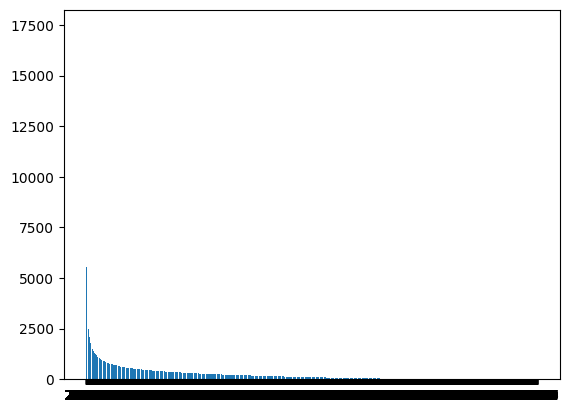

In [ ]:
#Plot bar for the item_freqs
plt.bar(items_freqs['item_id'], items_freqs['count'])
plt.show()

In [ ]:
item_full_session_array = full_sessions['item_id'].to_numpy()
item_full_session_array

array([ 9655,  9655, 15654, ..., 19483, 20782, 20782])

In [ ]:
def gini_index(list_of_values):
    sorted_list = sorted(list_of_values)
    height, area = 0, 0
    for value in sorted_list:
        height += value
        area += height - value / 2.
    fair_area = height * len(list_of_values) / 2.
    return (fair_area - area) / fair_area

In [ ]:
gini_co = gini_index(item_full_session_array)
gini_co

0.3348711456545782

## Temporal Aspects

**Temporal aspects**
* Interactions per day, week, month


In [ ]:
#From full_sessions, extract date, week, month, season
full_sessions['dateStr'] = full_sessions['date'].apply(lambda x: x.strftime('%Y-%m-%d'))
full_sessions['week'] = full_sessions['date'].apply(lambda x: x.strftime('%Y-%U'))
full_sessions['month'] = full_sessions['date'].apply(lambda x: x.strftime('%Y-%m'))

In [ ]:
full_sessions.head(5)

,session_id,item_id,date,timestamp,dateStr,week,month
0,3,9655,2020-12-18 21:25:00.373,1.608327e+09,2020-12-18,2020-50,2020-12
1,3,9655,2020-12-18 21:19:48.093,1.608326e+09,2020-12-18,2020-50,2020-12
2,13,15654,2020-03-13 19:35:27.136,1.584128e+09,2020-03-13,2020-10,2020-03
3,18,18316,2020-08-26 19:18:30.833,1.598470e+09,2020-08-26,2020-34,2020-08
4,18,2507,2020-08-26 19:16:31.211,1.598469e+09,2020-08-26,2020-34,2020-08


<Axes: xlabel='dateStr'>

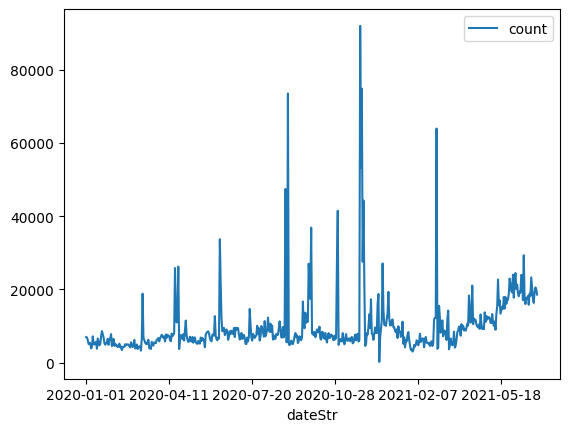

In [ ]:
#Interaction through time
full_sessions_dateStr = full_sessions['dateStr'].to_frame()
plot_full_sessions_dateStr = full_sessions_dateStr.groupby('dateStr', as_index=False).value_counts()
plot_full_sessions_dateStr.plot('dateStr', 'count')

<Axes: xlabel='week'>

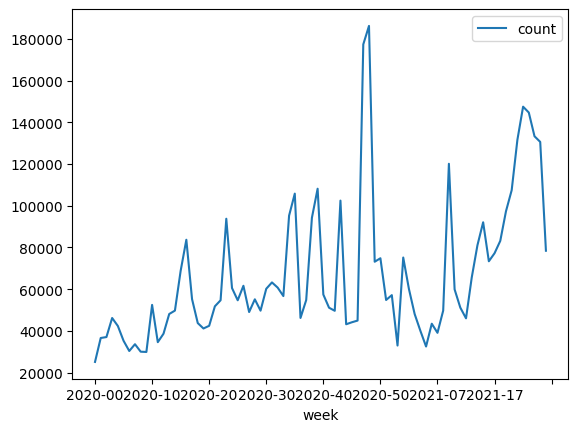

In [ ]:
#Distribution interactions by week
full_sessions_week = full_sessions['week'].to_frame()
plot_full_sessions_week = full_sessions_week.groupby('week', as_index=False).value_counts()
plot_full_sessions_week.plot('week', 'count')

<Axes: xlabel='month'>

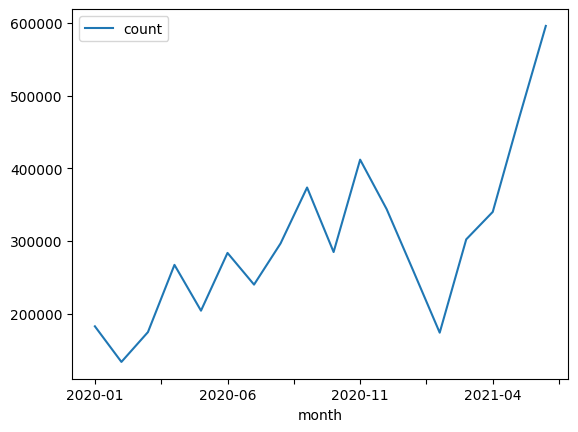

In [ ]:
#Distribution interactions by month
full_sessions_month = full_sessions['month'].to_frame()
plot_full_sessions_month = full_sessions_month.groupby('month', as_index=False).value_counts()
plot_full_sessions_month.plot('month', 'count')

# Item Cold-start

**Item Cold-start**
* How many new items every week/month
* % of interactions on new items first seen in the same day, week, month




# Session stats

**Session stats**
* Session length distribution
* Session duration distribution
* Percentage of session that has purchased at the end



In [ ]:
#Session length distribution
session_length = full_sessions.groupby('session_id').size()
session_length.describe(percentiles=[0.1, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.9])

count    1.100000e+06
mean     4.854375e+00
std      6.231568e+00
min      1.000000e+00
10%      1.000000e+00
20%      1.000000e+00
25%      1.000000e+00
30%      1.000000e+00
40%      2.000000e+00
50%      3.000000e+00
60%      4.000000e+00
70%      5.000000e+00
75%      6.000000e+00
80%      7.000000e+00
90%      1.100000e+01
max      1.000000e+02
dtype: float64

Conclude: The average length of session is 4.85

In [ ]:
session_length.head(5)

session_id
3      2
13     1
18     3
19    17
24     9
dtype: int64

In [ ]:
#Session duration distribution
session_duration = full_sessions.groupby('session_id').agg({'timestamp': ['min', 'max']})
session_duration['duration_sec'] = session_duration['timestamp']['max'] - session_duration['timestamp']['min']

In [ ]:
session_duration

timestamp               duration_sec
                     min           max             
session_id                                         
3           1.608326e+09  1.608327e+09      312.280
13          1.584128e+09  1.584128e+09        0.000
18          1.598469e+09  1.598470e+09      163.601
19          1.604335e+09  1.604336e+09     1082.965
24          1.582738e+09  1.582741e+09     3703.867
...                  ...           ...          ...
4439986     1.620906e+09  1.620907e+09      533.545
4439990     1.598096e+09  1.598100e+09     3458.541
4439994     1.606508e+09  1.606508e+09        0.000
4439999     1.606474e+09  1.606475e+09      436.076
4440001     1.604076e+09  1.604101e+09    25091.294

[1100000 rows x 3 columns]

In [ ]:
session_duration_describe = session_duration['duration_sec'].describe(percentiles=[0.1, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.9])
session_duration_describe

count    1.100000e+06
mean     2.209250e+03
std      7.428234e+03
min      0.000000e+00
10%      0.000000e+00
20%      0.000000e+00
25%      0.000000e+00
30%      0.000000e+00
40%      4.489600e+01
50%      1.065250e+02
60%      2.117010e+02
70%      4.105165e+02
75%      5.892790e+02
80%      9.002410e+02
90%      3.820120e+03
max      8.600671e+04
Name: duration_sec, dtype: float64

In [ ]:
#Percentage of sessions that has purchases at the end
pert_full_purchases = len(full_purchases)/len(full_sessions)
pert_full_purchases

0.20599976178936635

In [ ]:
pert_train_purchases = len(train_purchases)/len(train_sessions)
pert_train_purchases

0.21080057843678723

In [ ]:
pert_test_purchases = len(test_full_purchases)/len(test_full_sessions)
pert_test_purchases

0.1677874870803635